# Introdução

Neste notebook, criarei um modelo de rede neural capaz de classificar as imagens do dataset [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets) em cão ou gato. 

Utilizarei, majoritariamente, a biblioteca tensorflow+keras.

In [19]:
# importacao de bibliotecas necessarias

# bibliotecas de redes neurais
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.utils.vis_utils import plot_model

# bibliotecas de manipulacao de variaveis de ambiente e acesso a diretorios
import os, warnings
import glob

# bibliotecas de manipulacao e visualizacao de dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Leitura do Dataset

Optei por realizar a leitura local do dataset em vez do uso de tensorflow_datasets.load() pois essa biblioteca estava gerando um erro em minha máquina.

In [3]:
dir_name='dataset/images/*' # define a pasta onde estao as imagens

pets_files = glob.glob(dir_name)  # cria uma lista com o caminho dos arquivos encontrados dentro da pasta
pets_df = pd.DataFrame(pets_files) # transforma a lista em dataframe

In [4]:
pets_df.columns = ['full_path'] # renomeia a unica coluna do dataframe
pets_df['file_name'] = pets_df['full_path'].str.split('\\').str[1] # cria uma coluna chamada 'file_name' 
# composta pelo nome dos arquivos

Neste dataframe, conforme a documentação, arquivos que começam com letra maiúscula são imagens de gatos, enquanto arquivos que começam com letra minúscula são imagens de cachorros.

Vamos, então, mapear o nome dos arquivos para definir as classes.

In [5]:
pets_df['label'] = pets_df['file_name'].str[0].str.isupper().map({True:'1', False:'0'}) # mapeia arquivo
# com primeira letra maiuscula -> True = 1 = Gato, False = 0 = Cachorro

In [6]:
datagen = image.ImageDataGenerator(rescale=1/255., validation_split=0.2)
# como vamos trabalhar com as cores das imagens, torna-se necessario normalizar os valores do canal RGB para 0 a 1, por isso
# o argumento rescale=1/255

# utilizaremos 20% do dataset como validacao, e os outros 80% como treino.

train_generator = datagen.flow_from_dataframe(dataframe=pets_df.sample(pets_df.shape[0]), 
                                              directory= 'dataset/images',
                                              x_col='file_name',
                                              y_col='label',
                                              target_size=(256,256), # retransformamos as imagens em 256x256pixels
                                              class_mode='binary', # nossa classe é 0 ou 1, logo, binario.
                                              shuffle=False,
                                              subset='training'
                                             )

validation_generator = datagen.flow_from_dataframe(dataframe=pets_df.sample(pets_df.shape[0]), 
                                                   directory= 'dataset/images',
                                                   x_col='file_name',
                                                   y_col='label',
                                                   target_size=(256,256),
                                                   class_mode='binary',
                                                   shuffle=False,
                                                   subset='validation'
                                             )


# nao encontrei metodo para imprimir os arquivos que causam 
# "UserWarning: Found 3 invalid image filename(s) in x_col="file_name". These filename(s) will be ignored."
# e, caso eu use validate_filenames=False, o modelo nao compila devido a esses arquivos com erro.
# como a quantidade é baixa (6 contra 7390 validos), considerei irrelevante.

C:\Users\Ferrazzo\anaconda3\envs\tensorflorw\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 3 invalid image filename(s) in x_col="file_name". These filename(s) will be ignored.
  warnings.warn(


Found 5912 validated image filenames belonging to 2 classes.
Found 1478 validated image filenames belonging to 2 classes.


C:\Users\Ferrazzo\anaconda3\envs\tensorflorw\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 3 invalid image filename(s) in x_col="file_name". These filename(s) will be ignored.
  warnings.warn(


In [11]:
# vamos verificar a distribuicao de classes

ones_to_zeros_ratio_train = train_generator.__dict__['classes'].count(1)/len(train_generator.__dict__['classes'])
print(f"Nossa distribuicao de classes é de {ones_to_zeros_ratio_train * 100:.2}% no dataset de treino")

ones_to_zeros_ratio_validation = validation_generator.__dict__['classes'].count(1)/len(validation_generator.__dict__['classes'])
print(f"Nossa distribuicao de classes é de {ones_to_zeros_ratio_validation * 100:.2}% no dataset de treino")

Nossa razao entre as classes é de  32.070365358592696%


Isso implica que nosso dataset está desbalanceado. Pois, de todas imagens de gatos e cachorros, apenas ~32% são imagens de gatos.

Podemos, imaginar, então, que nosso modelo será melhor em predizer imagens de cachorros do que de gatos, pois teve uma carga de treino (e validação) maior em imagens de cachorros.

# Modelo

In [14]:
# durante algumas execucoes, meu modelo acabava estabilizando em uma acuracia nao ideal. 
# optei, entao, em deixar uma chamada para reduzir o Learning Rate (LR) atraves do metodo ReduceLROnPlateau
# que reduz o LR quando alguma metrica do modelo estabiliza

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', # qual metrica sera monitorada
                              factor=0.2, # fator de multiplicacao (no caso reducao) do learning rate
                              patience=5, # quantas epocas esperamos o "plateau"
                              min_lr=0.001 # menor learning rate possivel
                                )

In [13]:
model =  keras.Sequential([
    keras.layers.Conv2D(32,5,5, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2), padding='same'),
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(32, activation='relu'), 
    keras.layers.Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.SGD(learning_rate=0.02) 
# iniciamos com 0.02 de LR, e reduziremos com ReduceLROnPlateau caso necessario

model.compile(optimizer=optimizer, loss='BinaryCrossentropy', metrics=['accuracy'])

model_performance = model.fit(train_generator, 
                              validation_data= validation_generator, 
                              callbacks=[reduce_lr], 
                              epochs=80)


Epoch 1/80
185/185 [==============================] - 47s 247ms/step - loss: 0.6206 - accuracy: 0.6791 - val_loss: 0.6065 - val_accuracy: 0.6725
Epoch 2/80
185/185 [==============================] - 45s 242ms/step - loss: 0.6074 - accuracy: 0.6790 - val_loss: 0.6041 - val_accuracy: 0.6725
Epoch 3/80
185/185 [==============================] - 39s 209ms/step - loss: 0.5972 - accuracy: 0.6801 - val_loss: 0.5868 - val_accuracy: 0.6732
Epoch 4/80
185/185 [==============================] - 39s 210ms/step - loss: 0.5882 - accuracy: 0.6847 - val_loss: 0.5874 - val_accuracy: 0.6806
Epoch 5/80
185/185 [==============================] - 37s 202ms/step - loss: 0.5841 - accuracy: 0.6903 - val_loss: 0.5746 - val_accuracy: 0.6982
Epoch 6/80
185/185 [==============================] - 37s 199ms/step - loss: 0.5702 - accuracy: 0.6947 - val_loss: 0.5683 - val_accuracy: 0.6746
Epoch 7/80
185/185 [==============================] - 39s 209ms/step - loss: 0.5632 - accuracy: 0.7040 - val_loss: 0.5469 - val_ac

185/185 [==============================] - 57s 308ms/step - loss: 0.1280 - accuracy: 0.9603 - val_loss: 0.2273 - val_accuracy: 0.9384
Epoch 58/80
185/185 [==============================] - 57s 309ms/step - loss: 0.1265 - accuracy: 0.9636 - val_loss: 0.2274 - val_accuracy: 0.9398
Epoch 59/80
185/185 [==============================] - 58s 314ms/step - loss: 0.1260 - accuracy: 0.9630 - val_loss: 0.2267 - val_accuracy: 0.9398
Epoch 60/80
185/185 [==============================] - 57s 307ms/step - loss: 0.1241 - accuracy: 0.9652 - val_loss: 0.2255 - val_accuracy: 0.9425
Epoch 61/80
185/185 [==============================] - 56s 303ms/step - loss: 0.1226 - accuracy: 0.9643 - val_loss: 0.2250 - val_accuracy: 0.9418
Epoch 62/80
185/185 [==============================] - 56s 302ms/step - loss: 0.1262 - accuracy: 0.9604 - val_loss: 0.2232 - val_accuracy: 0.9425
Epoch 63/80
185/185 [==============================] - 56s 301ms/step - loss: 0.1234 - accuracy: 0.9624 - val_loss: 0.2256 - val_accurac

In [21]:
folder = 'models/94_val_acc_01_02_22'
model.save(folder)
pd.DataFrame.from_dict(model_performance.history).to_csv(folder + '/history.csv',index=False)

INFO:tensorflow:Assets written to: models/94_val_acc_01_02_22\assets


In [31]:
plot_model(model, 
           to_file=folder + 'model_plot.jpg', 
           show_shapes=True, 
           show_layer_names=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


# Análise das métricas

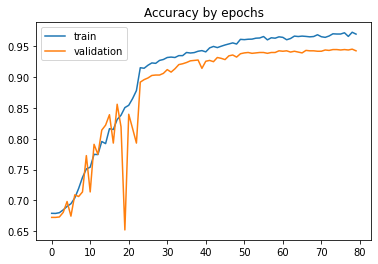

In [15]:
# Plot da acuracia de treino e validacao
plt.plot(model_performance.history['accuracy'])
plt.plot(model_performance.history['val_accuracy'])
plt.title('Accuracy by epochs')
plt.legend(['train', 'validation'])

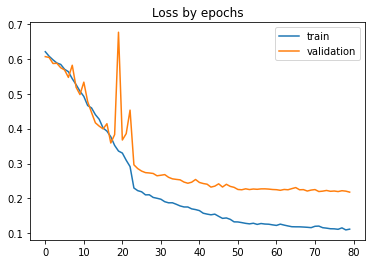

In [16]:
# Plot da perda de treino e validacao
plt.plot(model_performance.history['loss'])
plt.plot(model_performance.history['val_loss'])
plt.title('Loss by epochs')
plt.legend(['train', 'validation'])

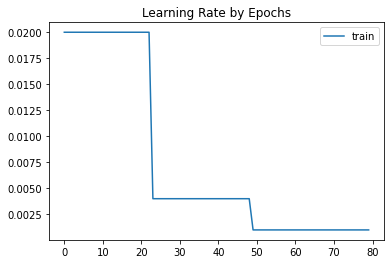

In [17]:
# Plot da variacao do Learning Rate
plt.plot(model_performance.history['lr'])
plt.title('Learning Rate by Epochs')
plt.legend(['train'])

In [32]:
# matriz de confusao
train_pred = model.predict(validation_generator)
confus_matrix = tf.math.confusion_matrix(labels=validation_generator.__dict__['classes'], predictions=train_pred.ravel()>0.5)

In [33]:
confus_matrix

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[956,  38],
       [ 47, 437]])>

In [ ]:
# adicionar o plot do modelo
# explicar o modelo
# tirar insights das metricas
# adicionar breves explicacoes no notebook de teste de imagens da web.